https://blog.yuugakujyuku.com/2023/01/06/kakezantest/

<img src="IMG_7744.jpeg" width=800>

In [1]:
using Distributions
using Printf
using Roots
using StatsFuns
using StatsPlots
default(fmt=:png)

In [2]:
safemul(x, y) = x == 0 ? x : isinf(x) ? oftype(x, Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

x ⪅ y = x < y || x ≈ y

mypdf(dist, x) = pdf(dist, x)
mypdf(dist::DiscreteUnivariateDistribution, x) = pdf(dist, round(Int, x))

distname(dist::Distribution) = replace(string(dist), r"{.*}" => "")
myskewness(dist) = skewness(dist)
mykurtosis(dist) = kurtosis(dist)
function standardized_moment(dist::ContinuousUnivariateDistribution, m)
    μ, σ = mean(dist), std(dist)
    quadgk(x -> (x - μ)^m * pdf(dist, x), extrema(dist)...)[1] / σ^m
end
myskewness(dist::MixtureModel{Univariate, Continuous}) =
    standardized_moment(dist, 3)
mykurtosis(dist::MixtureModel{Univariate, Continuous}) =
    standardized_moment(dist, 4) - 3

mykurtosis (generic function with 2 methods)

In [3]:
_riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)

function Delta(a, b, c, d; ρ=1.0)
    m, n = a+b, c+d
    A, B, C = ρ-1, n-a+ρ*(m-c), a*n-ρ*m*c
    Δ = isinf(ρ) ? oftype(ρ, -c) : ρ==0 ? oftype(ρ, a) : safediv(2C, B + √(B^2 - 4A*C))
end

function _chisqstat_rr(a, b, c, d, Δ)
    m, n = a+b, c+d
    safemul(Δ^2, safediv(b, m*(a-Δ)) + safediv(d, n*(c+Δ)))
end

function chisqstat_rr(a, b, c, d; ρ=1.0)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_pearson_chisq(a, b, c, d; ρ=1.0)
    χ² = chisqstat_rr(a, b, c, d; ρ)
    ccdf(Chisq(1), χ²)
end

function confint_rr_pearson_chisq(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0.0, Inf]
    f(logρ) = logit(pvalue_rr_pearson_chisq(a, b, c, d; ρ=exp(logρ))) - logit(α)
    L = if f(-Inf) > 0
        -Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat - 1
        find_zero(f, x0)
    end
    U = if f(Inf) > 0
        Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat + 1
        find_zero(f, x0)
    end
    [exp(L), exp(U)]
end

confint_rr_pearson_chisq (generic function with 1 method)

In [4]:
### score P-value for rate difference

riskdiffhat_score(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function loglik_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safemul(a, log(p)) + safemul(b, log(1-p)) + safemul(c, log(q)) + safemul(d, log(1-q))
end

function scorestat_q_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safediv(a, p) - safediv(b, 1-p) + safediv(c, q) - safediv(d, 1-q)
end

function d_scorestat_q_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    -safediv(a, p^2) - safediv(b, (1-p)^2) - safediv(c, q^2) - safediv(d, (1-q)^2)
end

function scorestat_Δ_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safediv(a, p) - safediv(b, 1-p)
end

function estimate_q_given_Δ_rd(a, b, c, d, Δ=0.0; alg=Bisection())
    qmin, qmax = max(0.0, -Δ), min(1.0, 1.0-Δ)
    a+c==0 && return qmin
    b+d==0 && return qmax
    f(q) = scorestat_q_rd(a, b, c, d, q, Δ)
    S_qmin = f(qmin + eps())
    S_qmax = f(qmax - eps())
    S_qmin ≥ 0 && S_qmax ≥ 0 && return S_qmin < S_qmax ? qmin : qmax
    S_qmin ≤ 0 && S_qmax ≤ 0 && return S_qmin < S_qmax ? qmax : qmin
    find_zero(f, (qmin + eps(), qmax - eps()), alg)
end

function varinv_scorestat_q_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safediv(p*(1-p), a+b) + safediv(q*(1-q), c+d)
end

function chisqstat_rd_score(a, b, c, d; Δ=0.0, alg=Bisection())
    abs(Δ) == 1 && return Inf
    q̃ = estimate_q_given_Δ_rd(a, b, c, d, Δ; alg)
    S = scorestat_Δ_rd(a, b, c, d, q̃, Δ)
    Vinv = varinv_scorestat_q_rd(a, b, c, d, q̃, Δ)
    safemul(S^2, Vinv)
end

function pvalue_rd_score(a, b, c, d; Δ=0.0, alg=Bisection())
    χ² = chisqstat_rd_score(a, b, c, d; Δ, alg)
    ccdf(Chisq(1), χ²)
end

function confint_rd_score(a, b, c, d; α=0.05, alg=Bisection())
    χ²_α = cquantile(Chisq(1), α)
    g(Δ) = chisqstat_rd_score(a, b, c, d; Δ, alg) - χ²_α
    Δ0 = riskdiffhat_score(a, b, c, d)
    L = if g(-1 + eps()) > 0
        find_zero(g, (-1 + eps(), Δ0), alg)
    else
        -1.0
    end
    U = if g(1 - eps()) > 0
        find_zero(g, (Δ0, 1 - eps()), alg)
    else
        1.0
    end
    [L, U]
end

confint_rd_score (generic function with 1 method)

In [5]:
__data = [
    75 64
    40 72
    75 72
    73 80
    59 72
    19 40
    66 72
    38 44
]

8×2 Matrix{Int64}:
 75  64
 40  72
 75  72
 73  80
 59  72
 19  40
 66  72
 38  44

In [6]:
mean(__data; dims=1)

1×2 Matrix{Float64}:
 55.625  64.5

In [7]:
_data = 0.01 * __data .* [73 25]

8×2 Matrix{Float64}:
 54.75  16.0
 29.2   18.0
 54.75  18.0
 53.29  20.0
 43.07  18.0
 13.87  10.0
 48.18  18.0
 27.74  11.0

In [8]:
_data = round.(Int, _data)

8×2 Matrix{Int64}:
 55  16
 29  18
 55  18
 53  20
 43  18
 14  10
 48  18
 28  11

In [9]:
__data2 = round.(Int, 100 * _data ./ [73 25])

8×2 Matrix{Int64}:
 75  64
 40  72
 75  72
 73  80
 59  72
 19  40
 66  72
 38  44

In [10]:
__data2 == __data

true

In [11]:
data = [_data[:,2] (25 .- _data[:,2]) _data[:,1] (73 .- _data[:,1])]

8×4 Matrix{Int64}:
 16   9  55  18
 18   7  29  44
 18   7  55  18
 20   5  53  20
 18   7  43  30
 10  15  14  59
 18   7  48  25
 11  14  28  45

In [12]:
@printf("%11s     %-4s         %-15s    %-15s    %-12s\n", "Problem No.", "data", "P-value of RR=1", "S-value of RR=1", "95% CI of RR")
println("-"^83)
for (i, A) in enumerate(eachrow(data))
    @printf("     %-6s [%2s %2s; %2s %2s]       %6.2f%%         %6.2f bit        [%4.2f, %4.2f]\n",
        i,
        A..., 
        100pvalue_rr_pearson_chisq(A...), 
        -log2(pvalue_rr_pearson_chisq(A...)), 
        confint_rr_pearson_chisq(A...)...
    )
end

Problem No.     data         P-value of RR=1    S-value of RR=1    95% CI of RR
-----------------------------------------------------------------------------------
     1      [16  9; 55 18]        27.33%           1.87 bit        [0.58, 1.12]
     2      [18  7; 29 44]         0.53%           7.56 bit        [1.21, 2.61]
     3      [18  7; 55 18]        74.07%           0.43 bit        [0.68, 1.22]
     4      [20  5; 53 20]        46.40%           1.11 bit        [0.82, 1.37]
     5      [18  7; 43 30]        24.37%           2.04 bit        [0.85, 1.63]
     6      [10 15; 14 59]         3.67%           4.77 bit        [1.05, 3.97]
     7      [18  7; 48 25]        56.54%           0.82 bit        [0.77, 1.43]
     8      [11 14; 28 45]        61.88%           0.69 bit        [0.65, 1.87]


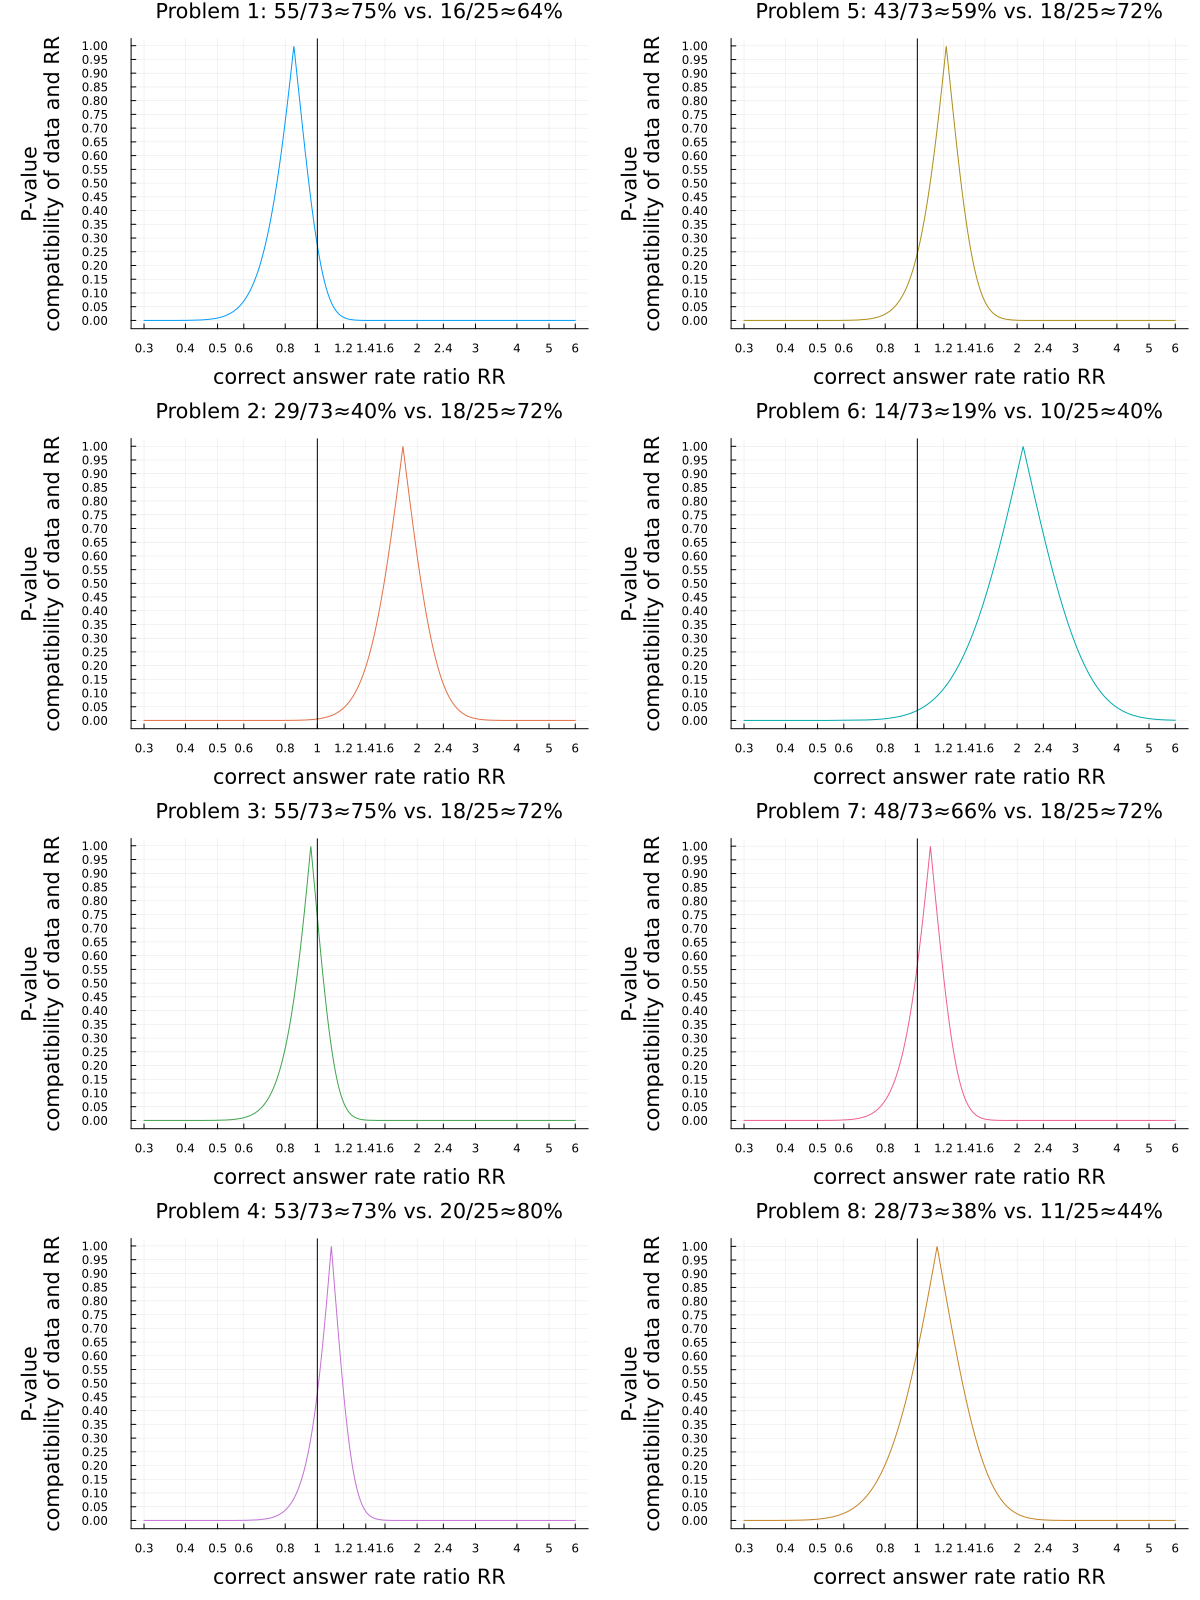

In [13]:
PP = []
for (i, A) in enumerate(eachrow(data))
    a, b, c, d = A
    R1 = round(Int, 100a/(a+b))
    R2 = round(Int, 100c/(c+d))
    P = plot(ρ ->pvalue_rr_pearson_chisq(A...; ρ), 0.3, 6; label="", c=i)
    vline!([1]; label="", c=:black)
    plot!(xscale=:log10)
    xtick = Any[0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 2, 2.4, 3, 4, 5, 6]
    xtick =(xtick, string.(xtick))
    plot!(; xtick, ytick=0:0.05:1)
    plot!(xguide="correct answer rate ratio RR", 
        yguide="P-value\ncompatibility of data and RR")
    title!("Problem $i: $c/$(c+d)≈$(R2)% vs. $a/$(a+b)≈$(R1)%")
    push!(PP, P)
end

plot((isodd(i) ? PP[i÷2+1] : PP[i÷2+4] for i in 1:8)...; size=(1200, 1600), layout=(4, 2))
plot!(leftmargin=10Plots.mm)
plot!(guidefontsize=14)

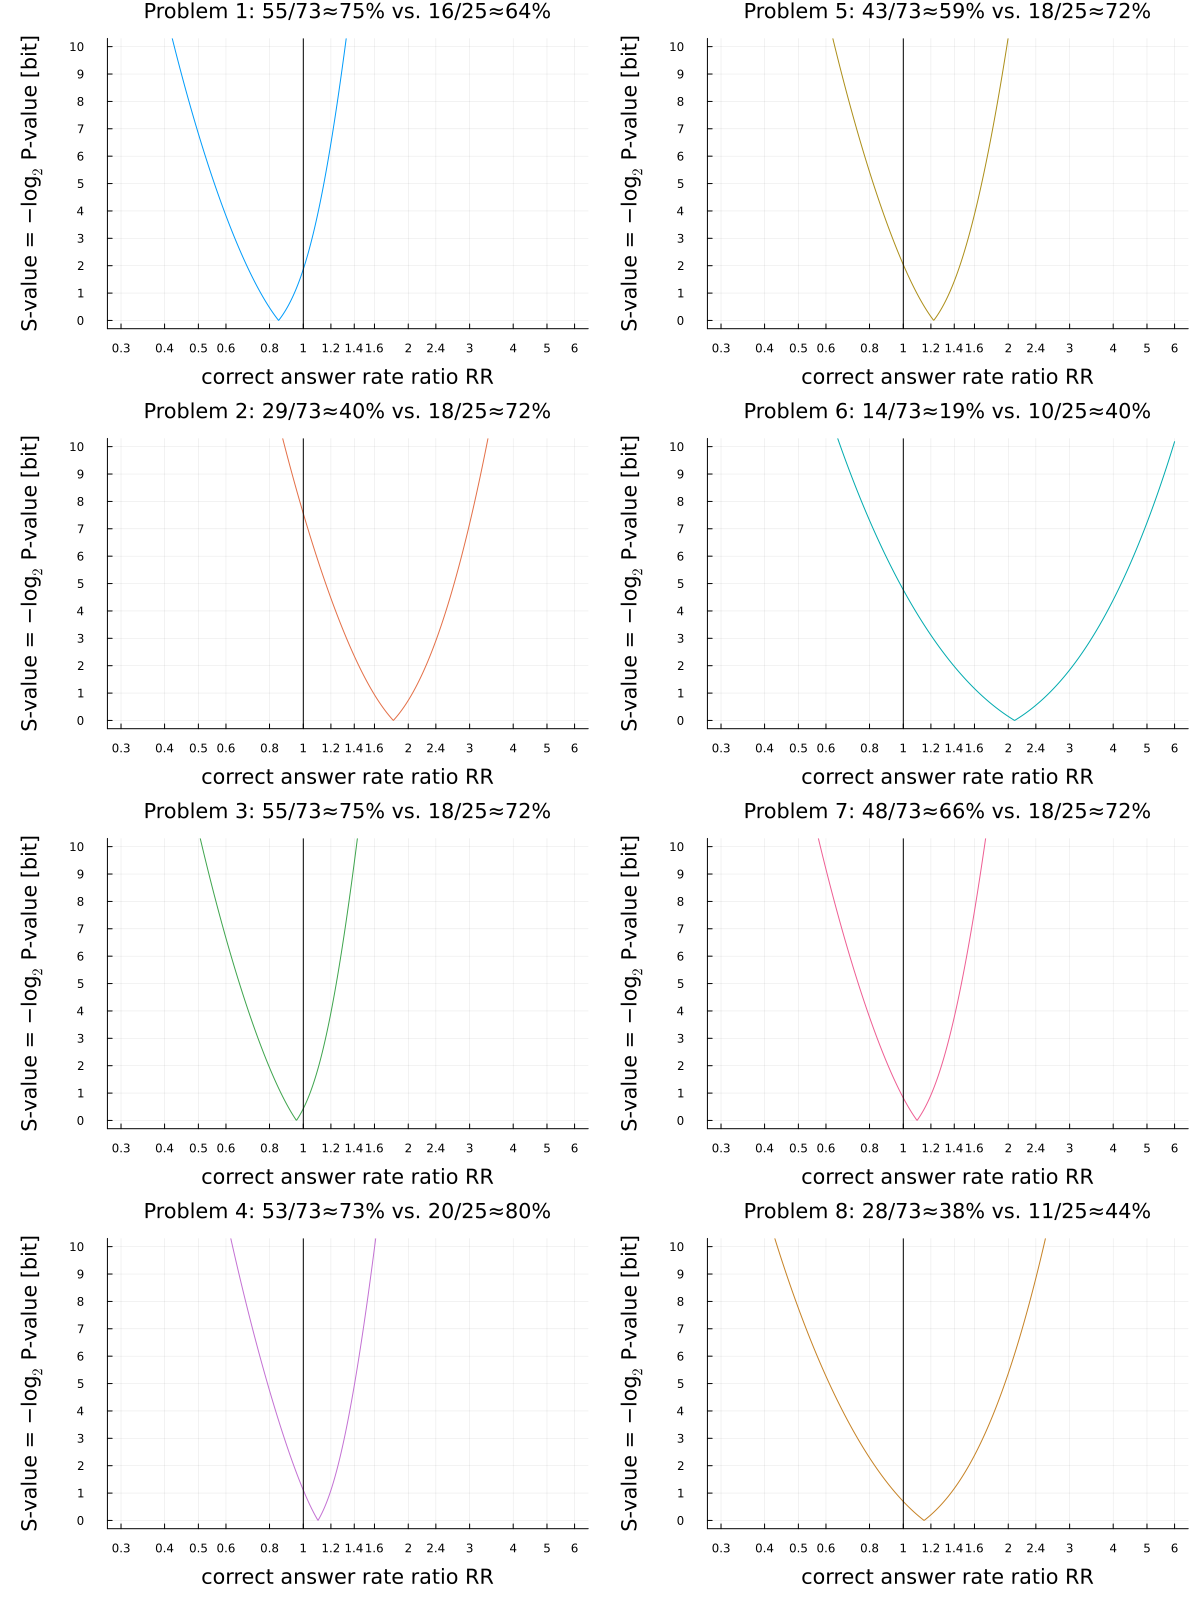

In [14]:
PP = []
for (i, A) in enumerate(eachrow(data))
    a, b, c, d = A
    R1 = round(Int, 100a/(a+b))
    R2 = round(Int, 100c/(c+d))
    ρs = 10.0 .^ range(log10(0.3), log10(6), 1000)
    P = plot(ρs, ρ ->-log2(pvalue_rr_pearson_chisq(A...; ρ)); label="", c=i)
    vline!([1]; label="", c=:black)
    plot!(xscale=:log10)
    xtick = Any[0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 2, 2.4, 3, 4, 5, 6]
    xtick =(xtick, string.(xtick))
    plot!(; xtick)
    plot!(ylim=(-0.3, 10.3), ytick=0:10)
    plot!(xguide="correct answer rate ratio RR", 
        yguide="S-value = −log\${}_2\$ P-value [bit]")
    title!("Problem $i: $c/$(c+d)≈$(R2)% vs. $a/$(a+b)≈$(R1)%")
    push!(PP, P)
end

plot((isodd(i) ? PP[i÷2+1] : PP[i÷2+4] for i in 1:8)...; size=(1200, 1600), layout=(4, 2))
plot!(leftmargin=12Plots.mm)
plot!(guidefontsize=14)

In [15]:
@printf("%11s     %-4s         %-15s    %-15s    %-12s\n", "Problem No.", "data", "P-value of RD=0", "S-value of RD=0", "95% CI of RD")
println("-"^82)
for (i, A) in enumerate(eachrow(data))
    @printf("     %-6s [%2s %2s; %2s %2s]       %6.2f%%         %6.2f bit        [%5.2f, %5.2f]\n",
        i,
        A..., 
        100pvalue_rd_score(A...), 
        -log2(pvalue_rd_score(A...)), 
        confint_rd_score(A...)...
    )
end

Problem No.     data         P-value of RD=0    S-value of RD=0    95% CI of RD
----------------------------------------------------------------------------------
     1      [16  9; 55 18]        27.33%           1.87 bit        [-0.33,  0.08]
     2      [18  7; 29 44]         0.53%           7.56 bit        [ 0.10,  0.50]
     3      [18  7; 55 18]        74.07%           0.43 bit        [-0.25,  0.15]
     4      [20  5; 53 20]        46.40%           1.11 bit        [-0.14,  0.24]
     5      [18  7; 43 30]        24.37%           2.04 bit        [-0.09,  0.32]
     6      [10 15; 14 59]         3.67%           4.77 bit        [ 0.01,  0.42]
     7      [18  7; 48 25]        56.54%           0.82 bit        [-0.16,  0.25]
     8      [11 14; 28 45]        61.88%           0.69 bit        [-0.15,  0.28]


In [16]:
for (i, A) in enumerate(eachrow(data))
    a, b, c, d = A
    bin0 = Binomial(a+b, (a+c)/(a+b+c+d))
    pval0 = min(2cdf(bin0, a), 2ccdf(bin0, a))
    bin1 = Binomial(a+b, c/(c+d))
    pval1 = min(2cdf(bin1, a), 2ccdf(bin1, a))
    bin2 = Binomial(c+d, a/(a+b))
    pval2 = min(2cdf(bin2, c), 2ccdf(bin2, c))
    @printf "%4d  %6.2f%%  %6.2f%%  %6.2f%%  %6.2f%%\n" i 100pvalue_rd_score(A...) 100pval0 100pval1 100pval2
end

   1   27.33%   46.09%   28.00%    2.81%
   2    0.53%    0.82%    0.05%    0.00%
   3   74.07%   92.50%   84.61%   44.84%
   4   46.40%   39.48%   28.95%   15.89%
   5   24.37%   22.13%   11.89%    2.18%
   6    3.67%    5.13%    0.79%    0.02%
   7   56.54%   48.69%   38.84%   29.06%
   8   61.88%   52.16%   42.88%   39.42%


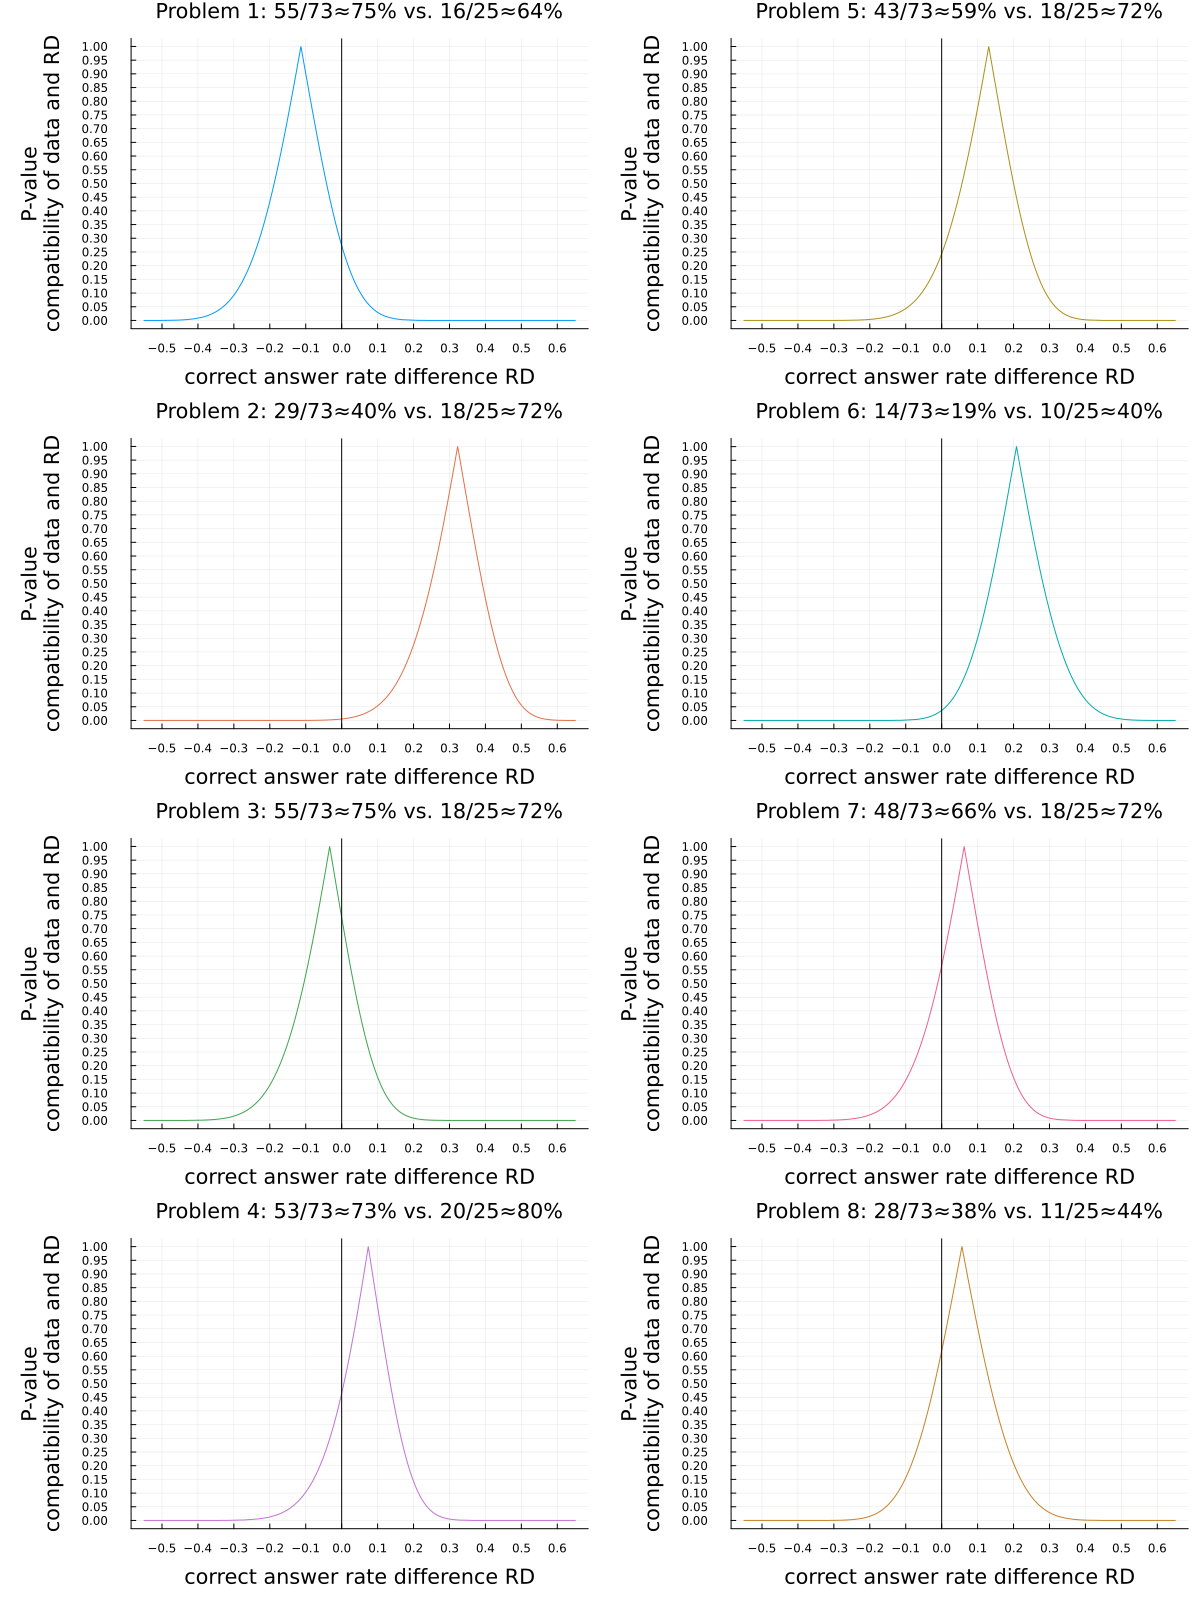

In [17]:
PP = []
for (i, A) in enumerate(eachrow(data))
    a, b, c, d = A
    R1 = round(Int, 100a/(a+b))
    R2 = round(Int, 100c/(c+d))
    P = plot(Δ ->pvalue_rd_score(A...; Δ), -0.55, 0.65; label="", c=i)
    vline!([0]; label="", c=:black)
    plot!(; xtick=-1:0.1:1, ytick=0:0.05:1)
    plot!(xguide="correct answer rate difference RD", 
        yguide="P-value\ncompatibility of data and RD")
    title!("Problem $i: $c/$(c+d)≈$(R2)% vs. $a/$(a+b)≈$(R1)%")
    push!(PP, P)
end

plot((isodd(i) ? PP[i÷2+1] : PP[i÷2+4] for i in 1:8)...; size=(1200, 1600), layout=(4, 2))
plot!(leftmargin=10Plots.mm)
plot!(guidefontsize=14)

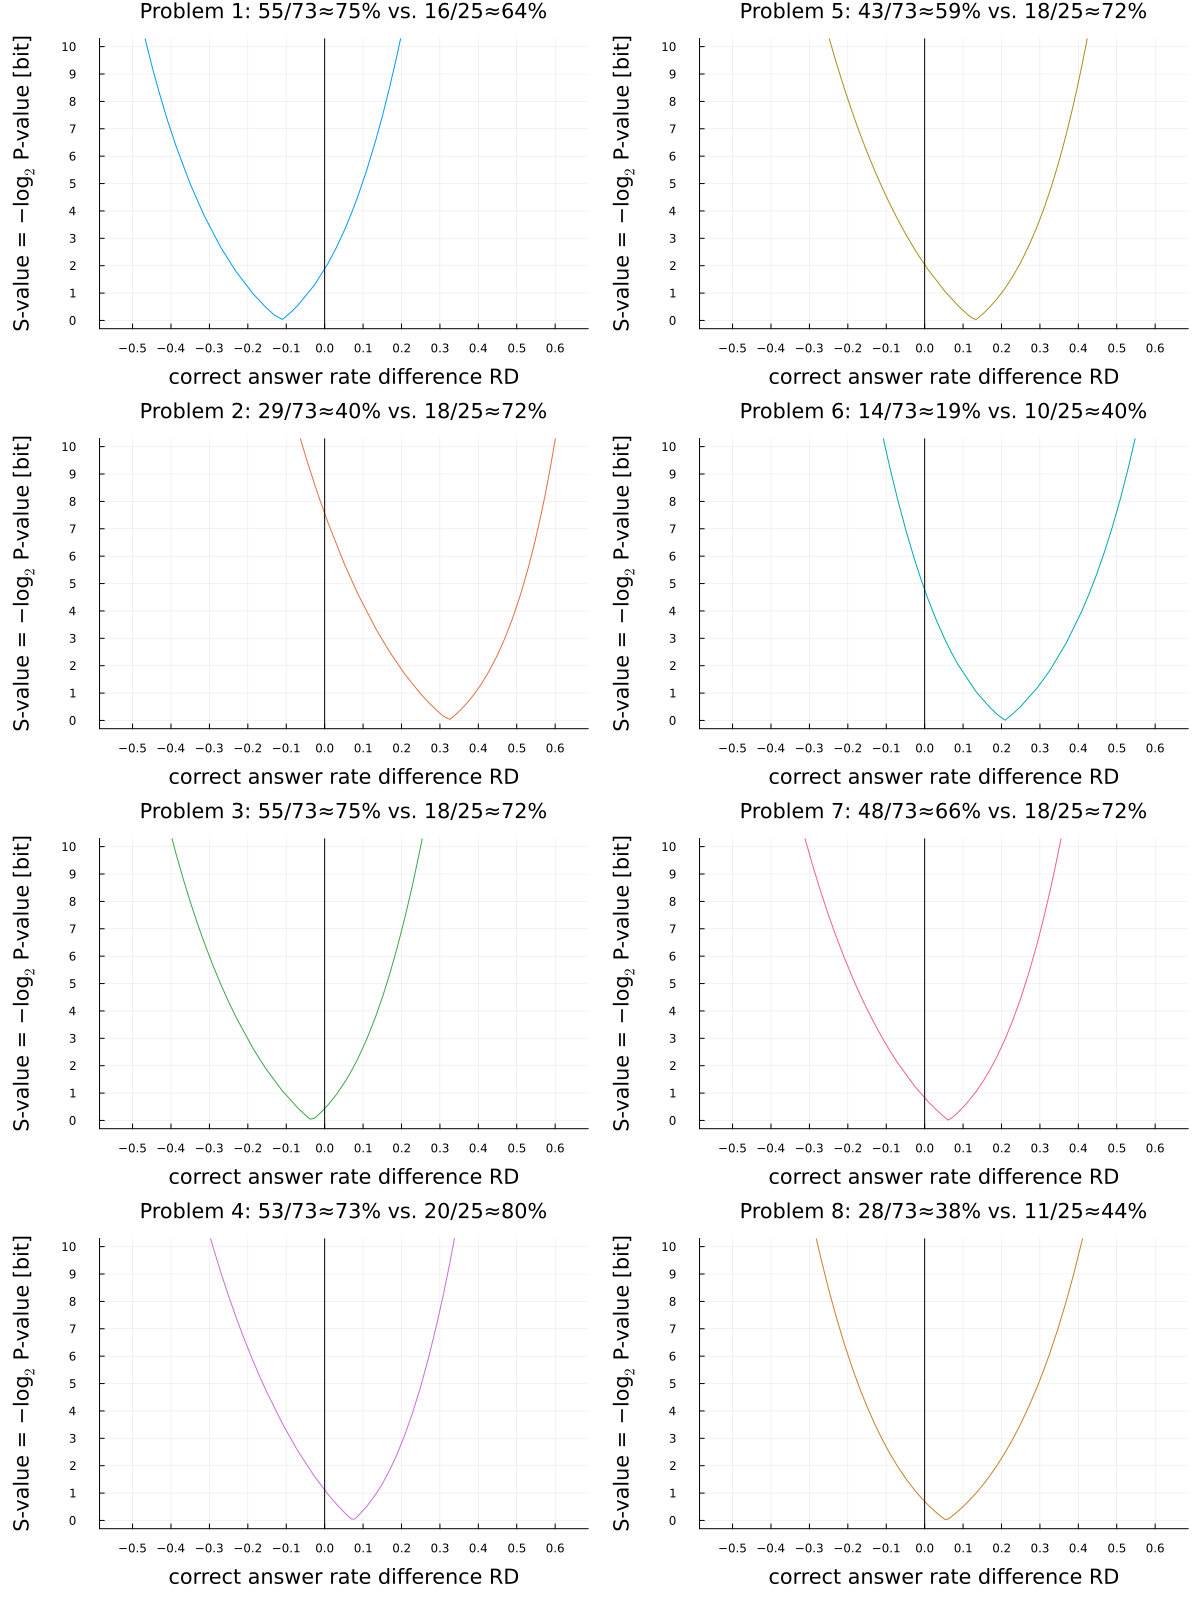

In [18]:
PP = []
for (i, A) in enumerate(eachrow(data))
    a, b, c, d = A
    R1 = round(Int, 100a/(a+b))
    R2 = round(Int, 100c/(c+d))
    P = plot(Δ -> -log2(pvalue_rd_score(A...; Δ)), -0.55, 0.65; label="", c=i)
    vline!([0]; label="", c=:black)
    plot!(; xtick=-1:0.1:1)
    plot!(; ylim=(-0.3, 10.3), ytick=0:10)
    plot!(xguide="correct answer rate difference RD", 
        yguide="S-value = −log\$_2\$ P-value [bit]")
    title!("Problem $i: $c/$(c+d)≈$(R2)% vs. $a/$(a+b)≈$(R1)%")
    push!(PP, P)
end

plot((isodd(i) ? PP[i÷2+1] : PP[i÷2+4] for i in 1:8)...; size=(1200, 1600), layout=(4, 2))
plot!(leftmargin=10Plots.mm)
plot!(guidefontsize=14)